In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
import matplotlib.pyplot as plt

In [2]:
# 1.加载数据集
batch_size = 512  #每个batch多少张图片
#读取训练集
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data',  #数据存储路径，如果不存在下载后会存到此路径
                               train=True, download=True,  #如果本地不存在，则下载数据
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),  #数据类型转为tensor格式
                                   torchvision.transforms.Normalize(  #将数据Normalize处理，类似归一化
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=True)
#读取测试集
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=True)

In [3]:
print(len(train_loader))
examples = enumerate(train_loader)
#读取第一个batch
batch_idx, (example_data, example_targets) = next(examples)
print(batch_idx)
print(example_targets)
print(example_data)

118
0
tensor([8, 4, 8, 3, 7, 8, 5, 2, 9, 1, 0, 5, 3, 7, 8, 3, 0, 7, 4, 8, 1, 0, 2, 6,
        2, 8, 7, 7, 5, 5, 5, 2, 2, 6, 1, 8, 5, 0, 9, 6, 5, 9, 4, 2, 1, 1, 2, 8,
        9, 5, 4, 3, 4, 0, 8, 7, 0, 9, 3, 6, 3, 6, 5, 1, 0, 1, 3, 4, 7, 4, 8, 9,
        6, 2, 4, 7, 5, 8, 9, 7, 3, 4, 0, 7, 1, 2, 7, 2, 3, 1, 6, 8, 6, 3, 2, 9,
        4, 2, 7, 0, 3, 8, 5, 3, 8, 9, 0, 8, 9, 9, 0, 5, 1, 7, 4, 8, 4, 0, 7, 9,
        2, 2, 4, 9, 6, 8, 1, 7, 9, 7, 9, 6, 3, 3, 3, 4, 4, 6, 7, 2, 0, 1, 1, 5,
        9, 6, 3, 9, 3, 0, 3, 8, 8, 2, 4, 9, 2, 3, 7, 9, 8, 5, 1, 6, 1, 2, 9, 6,
        2, 9, 6, 5, 5, 5, 3, 8, 0, 8, 7, 8, 6, 7, 3, 2, 3, 8, 4, 9, 3, 0, 1, 4,
        4, 7, 6, 5, 4, 4, 5, 9, 4, 3, 8, 7, 8, 1, 8, 4, 0, 0, 1, 2, 2, 7, 6, 7,
        2, 3, 3, 4, 8, 4, 8, 7, 1, 4, 8, 3, 7, 6, 9, 9, 6, 8, 1, 7, 8, 2, 1, 1,
        5, 5, 1, 1, 4, 7, 3, 7, 8, 0, 4, 3, 0, 1, 3, 5, 7, 6, 0, 2, 1, 2, 3, 2,
        2, 0, 5, 3, 5, 3, 4, 7, 6, 7, 1, 9, 9, 2, 7, 0, 7, 6, 6, 3, 7, 9, 8, 7,
        3, 1, 0, 9, 1, 9, 9, 1, 0,

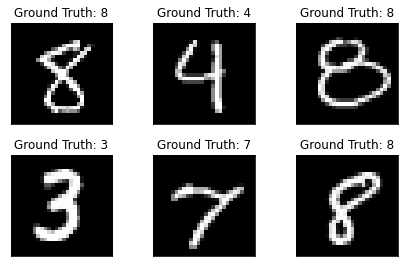

In [4]:
# 绘制数字图片
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [5]:
def one_hot(label, depth=10):
    out = torch.zeros(label.size(0), depth)
    idx = torch.LongTensor(label).view(-1, 1)
    out.scatter_(dim=1, index=idx, value=1)
    return out
# 网络层全部用全连接，激活函数用relu
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #xw+b
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        #输出层
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # x的维度索引:[i,1,28,28]
        # 计算过程
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
#梯度下降优化器
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
train_loss = []
for epoch in range(3):
    for batch_idx, (x, y) in enumerate(train_loader):
        # print(batch_idx,x.shape,y.shape)
        # x的维度是[512,1,28,28]
        # x.size(0)=512，x.size(1)=1，就是取出x的维度信息
        # 将x的shape进行转换，[512,1,28,28]=>[512,28*28]
        x = x.view(x.size(0), 28 * 28)
        #相当于调用了forward函数，out就是输出的10维label
        out = net(x)
        y_onehot=one_hot(y)
        loss = F.mse_loss(out, y_onehot)
        optimizer.zero_grad()
        loss.backward()
        # 更新优化w'，即w' = w - lr*grad
        optimizer.step()
        train_loss.append(loss.item())
        # 每10个batch输出一次loss结果
        if batch_idx % 10 == 0:
            print(epoch, batch_idx, loss.item())

0 0 0.11745520681142807
0 10 0.09180663526058197
0 20 0.08342482149600983
0 30 0.07654788345098495
0 40 0.07096066325902939
0 50 0.06374233961105347
0 60 0.05912093073129654
0 70 0.05748555809259415
0 80 0.05270034074783325
0 90 0.050733793526887894
0 100 0.0486188605427742
0 110 0.04647868499159813
1 0 0.04459138214588165
1 10 0.044025201350450516
1 20 0.04309786856174469
1 30 0.04223521426320076
1 40 0.04238222911953926
1 50 0.03992732614278793
1 60 0.03832240775227547
1 70 0.03865973278880119
1 80 0.03991305083036423
1 90 0.039131440222263336
1 100 0.038484182208776474
1 110 0.037374649196863174
2 0 0.03606514260172844
2 10 0.03541335463523865
2 20 0.03550396487116814
2 30 0.03499462455511093
2 40 0.03529138118028641
2 50 0.03365803509950638
2 60 0.034925054758787155
2 70 0.03243169188499451
2 80 0.03353046253323555
2 90 0.033127330243587494
2 100 0.03242652863264084
2 110 0.031140049919486046


In [7]:
predict=torch.argmax(net(example_data[1:7].reshape(6,28*28)),axis=1)
predict

tensor([4, 3, 3, 7, 8, 5])

In [8]:
example_targets[1:7]

tensor([4, 8, 3, 7, 8, 5])

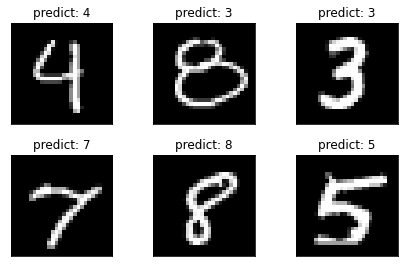

In [9]:
fig = plt.figure()
for i in range(1,7):
    plt.subplot(2, 3, i)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("predict: {}".format(predict[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [48]:
predict=net(test_loader.dataset.data.reshape(-1, 28 * 28).to(torch.float32))
predict

tensor([[  2.2459,  -7.0495,   4.3008,  ...,  59.9257,   1.9547,  -4.5579],
        [ 16.8349, -19.2252,  38.1483,  ...,  -4.9329,   5.3892, -11.9693],
        [ -0.2937,  34.2142,   3.6671,  ...,  -0.1134,   8.1120,  -4.7565],
        ...,
        [ -2.5524,  -9.1850,  -3.8000,  ...,   4.7798,  21.3665,  16.0345],
        [  1.3266,  -3.6462,  -2.2517,  ...,  -2.0857,  27.1853,  -5.9520],
        [ 13.3280, -15.9729,  13.2527,  ...,   0.2541,  -1.0649,  -6.0508]],
       grad_fn=<AddmmBackward0>)

In [50]:
sum(torch.argmax(predict,axis=1)==test_loader.dataset.targets)/len(predict)

tensor(0.8651)